# Data Science Essentials: GeoPandas
    Marcelo Leszynski
    Vol 3 Labs
    09/21/21

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

[]

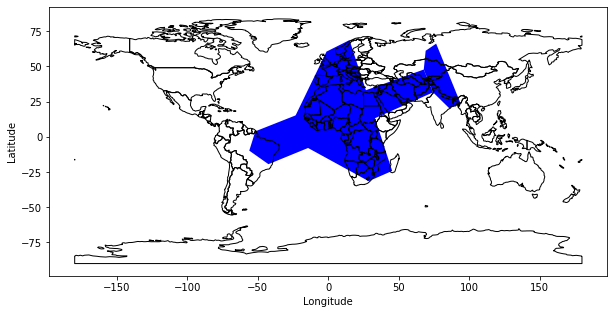

In [2]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

airports = pd.read_csv('airports.csv')
airports = airports.set_index('Name')

# create base of plot 
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)

# filter for correct airports
first_ports = airports.loc[first_set]
second_ports = airports.loc[second_set]
third_ports = airports.loc[third_set]

# create coordinate lists for airports
p1 = list(zip(first_ports.Longitude, first_ports.Latitude))
p2 = list(zip(second_ports.Longitude, second_ports.Latitude))
p3 = list(zip(third_ports.Longitude, third_ports.Latitude))

# create the plot
df = pd.DataFrame({'Polygons':[p1,p2,p3]})
df['Polygons'] = df['Polygons'].apply(Polygon)
gdf = gpd.GeoDataFrame(df, geometry='Polygons')
gdf.plot(ax=base, marker='o', color='blue', markersize=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.plot()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

[]

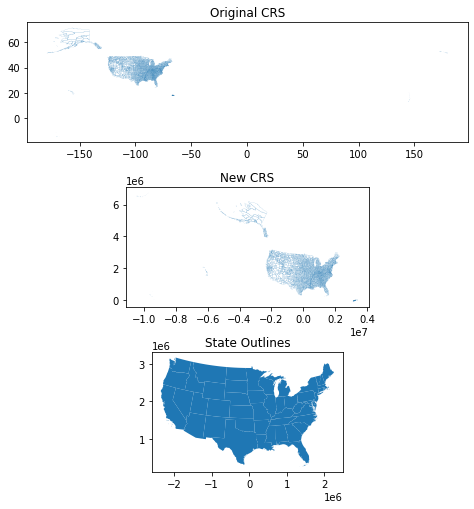

In [3]:
# read in data and set up fig, ax
counties = gpd.read_file('county_data.gpkg')
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=3)

# plot with original CRS
counties.boundary.plot(ax=ax[0], linewidth=0.1, alpha=0.8)
ax[0].set_title('Original CRS')
plt.tight_layout()

# change and plot with updated CRS
counties.to_crs(5071, inplace=True)
counties.boundary.plot(ax=ax[1], linewidth=0.1, alpha=0.8)
ax[1].set_title('New CRS')
plt.tight_layout()

# get and plot state outlines
states = counties.dissolve(by = 'STATEFP', aggfunc='sum')
to_drop = ['02','15','60','66','69','72','78']
states = states.drop(to_drop)
states.to_crs(5071, inplace=True)
states.plot(ax=ax[2])
ax[2].set_title('State Outlines')

plt.plot()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will not use rows in the Covid-19 DataFrame with unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska and rows with unknown FIPS codes.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases on March 21, 2020 along with its case count.**

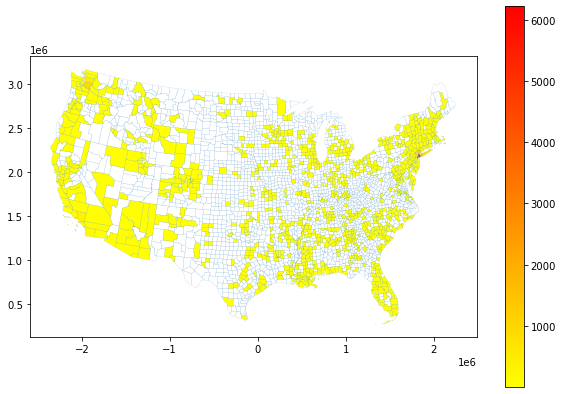

County: New York City, Case count: 6226


In [4]:
# read in data
df = pd.read_csv('nytimes.csv')

# perform desired manipulations pre-join
df['date'] = pd.to_datetime(df['date'])
counties = counties.drop(counties[counties.STATEFP.isin(to_drop)].index)
counties['fips'] = counties['STATEFP']+counties['COUNTYFP']
counties = counties.astype({'fips':'float64'})

# perform the merge of dataframes
covid_df = counties.merge(df, on='fips')

# plot the results
fig, ax = plt.subplots(1, figsize=(10,7))
counties.boundary.plot(ax=ax, linewidth=0.1, alpha=0.8)
covid_df[covid_df.date == pd.to_datetime('03/21/2020')].plot(column='cases', cmap='autumn_r', legend=True, ax=ax)
plt.show()

# return the answer to the questions
maxcounty = covid_df[covid_df.date == pd.to_datetime('03/21/2020')].cases.idxmax()
print("County: " + covid_df.iloc[maxcounty].county + ", Case count: " + str(covid_df.iloc[maxcounty].cases))

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

<AxesSubplot:>

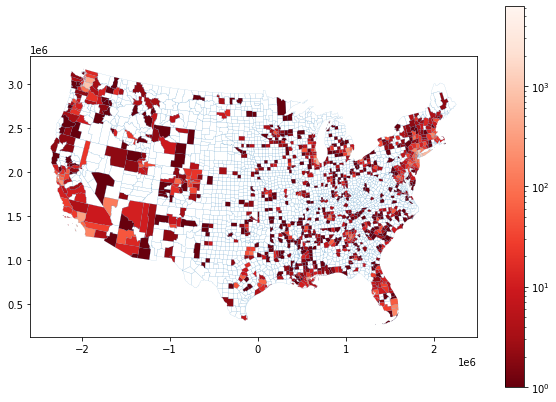

In [5]:
# perform calculations
df_2 = covid_df[covid_df.date == pd.to_datetime('03/21/2020')].cases
norm = LogNorm(vmin=min(df_2), vmax=max(df_2))

# plot results
fig, ax = plt.subplots(1, figsize=(10,7))
counties.boundary.plot(ax=ax, linewidth=0.1, alpha=0.8)
covid_df[covid_df.date == pd.to_datetime('03/21/2020')].plot(column='cases', cmap='Reds_r', legend=True, ax=ax, norm=norm)

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation and embed it.

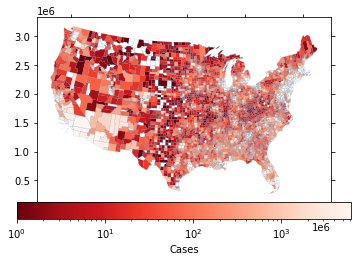

In [6]:
#Set up figure and norm
fig = plt.figure()
dates = pd.date_range(start='01/01/2020', end='06/21/2020')
date_locs = [covid_df[covid_df.date == date].index for date in dates]
ax = fig.add_subplot(111)

def update(date):
    ax.clear()
    base = counties.boundary.plot(ax=ax, linewidth=0.1, alpha=0.8)
    if (len(date)>0):
        #Plot the cases from a single day
        covid_df.iloc[date].plot(column='cases', cmap='Reds_r', ax=base, norm=norm)
    return ax

#Set up the colorbar
c_bar = fig.colorbar(ScalarMappable(norm=norm, cmap='Reds_r'), ax=ax, orientation='horizontal', pad=0, label='Cases')

#Create and embed the animation
ani = animation.FuncAnimation(fig, update, frames=date_locs, interval=100)
HTML(ani.to_html5_video())